<a href="https://colab.research.google.com/github/gmazzitelli/studenti/blob/master/covid19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

COVID-19 Workaround 

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
# download updated data
# repository italy https://github.com/pcm-dpc/COVID-19/tree/master/dati-andamento-nazionale
url_csv_file = "https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv"
df = pd.read_csv(url_csv_file)
df.head()

,data,stato,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_attualmente_positivi,nuovi_attualmente_positivi,dimessi_guariti,deceduti,totale_casi,tamponi
0,2020-02-24 18:00:00,ITA,101,26,127,94,221,221,1,7,229,4324
1,2020-02-25 18:00:00,ITA,114,35,150,162,311,90,1,10,322,8623
2,2020-02-26 18:00:00,ITA,128,36,164,221,385,74,3,12,400,9587
3,2020-02-27 18:00:00,ITA,248,56,304,284,588,203,45,17,650,12014
4,2020-02-28 18:00:00,ITA,345,64,409,412,821,233,46,21,888,15695


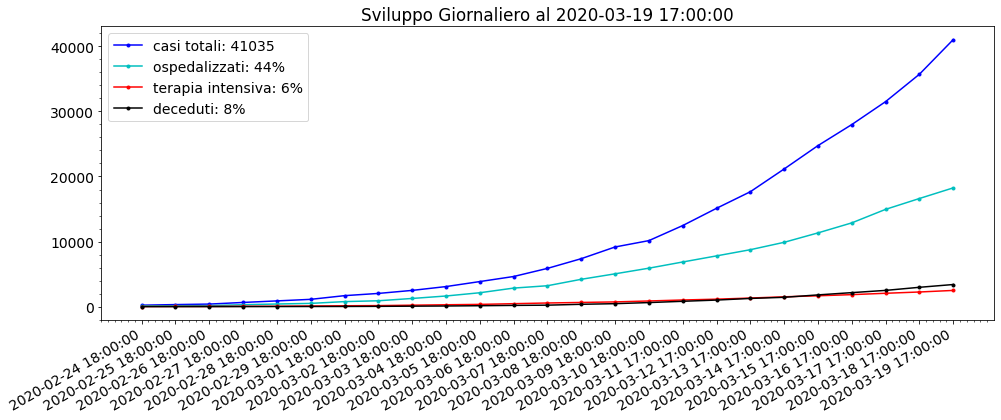

In [4]:
# visualize Daly data of infected and death people
plt.style.use('fast')
plt.rc('font', size = 14, family ='Sans-Serif')
fig, ax = plt.subplots(figsize=(16,6))
fig.autofmt_xdate()
ax.plot(df['data'], df['totale_casi'], 'b.-', label='casi totali: '+str(np.array(df['totale_casi'])[-1]))
perc_ospedalizzati = 100*np.array(df['totale_ospedalizzati'])[-1]/np.array(df['totale_casi'])[-1]
ax.plot(df['data'], df['totale_ospedalizzati'], 'c.-', label='ospedalizzati: {0:.0f}%'.format(perc_ospedalizzati))
perc_intensiva = 100*np.array(df['terapia_intensiva'])[-1]/np.array(df['totale_casi'])[-1]
ax.plot(df['data'], df['terapia_intensiva'], 'r.-', label='terapia intensiva: {0:.0f}%'.format(perc_intensiva))
perc_deceduti = 100*np.array(df['deceduti'])[-1]/np.array(df['totale_casi'])[-1]
ax.plot(df['data'], df['deceduti'], 'k.-', label='deceduti: {0:.0f}%'.format(perc_deceduti))
#ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_date))
ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.set_title('Sviluppo Giornaliero al '+str(np.array(df['data'])[-1]))
#ax.set_yscale('log')
ax.legend(loc=2)
plt.minorticks_on()
plt.show()

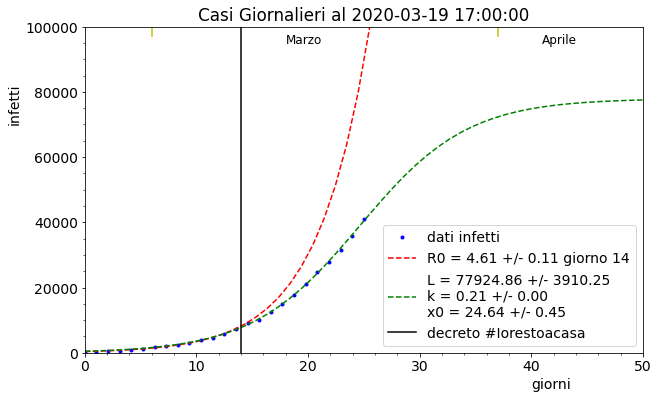

In [5]:
def Exp(x, p0, p1): # negative exponential

    import numpy as np
    return p0*np.exp(x/p1)

def Logistic(x, L, k, x0):
    return L / (1. + np.exp(-k * (x - x0)))

def Gompertz(x, a, b, c):
# https://en.wikipedia.org/wiki/Gompertz_function
    return a * np.exp(-b * np.exp(-c * x))


from scipy.optimize import curve_fit
x = np.linspace(0, len(df['data']), len(df['data']))

max_exp_fit = 14
popt_e,pcov_e = curve_fit(Exp,x[x<max_exp_fit], df['totale_casi'][x<max_exp_fit], p0=[1,2])
perr_e = np.sqrt(np.diag(pcov_e))
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(x, df['totale_casi'], 'b.', label='dati infetti')
popt_l,pcov_l = curve_fit(Logistic,x, df['totale_casi'], p0=[4000.,4., 10.])
perr_l = np.sqrt(np.diag(pcov_l))
x=np.linspace(0,50,50)
ax.plot(x, Exp(x, *popt_e), 'r--', label='R0 = {0:.2f} +/- {1:.2f} giorno {2:d}'.format(popt_e[1], perr_e[1], max_exp_fit))
ax.plot(x, Logistic(x, *popt_l), 'g--', label='L = {0:.2f} +/- {1:.2f}\nk = {2:.2f} +/- {3:.2f} \
\nx0 = {4:.2f} +/- {5:.2f}'.format(popt_l[0], perr_l[0], popt_l[1], perr_l[1], popt_l[2], perr_l[2]))
ax.set_xlim(0,50)
ax.set_ylim(0,100000)
ax.plot([14,14], [0,100000], 'k-', label='decreto #Iorestoacasa')
ax.plot([6,6], [97000,100000], 'y-')
ax.plot([6+31,6+31], [97000,100000], 'y-')
ax.text(6+35, 95000, 'Aprile', fontsize=12)
ax.text(6+12, 95000, 'Marzo', fontsize=12)
ax.set_title('Casi Giornalieri al '+str(np.array(df['data'])[-1]))
ax.legend(loc=4)
ax.set_xlabel('giorni', horizontalalignment = 'left', x=0.8)
ax.set_ylabel('infetti', horizontalalignment = 'left', y=0.7)
plt.minorticks_on()
plt.show()


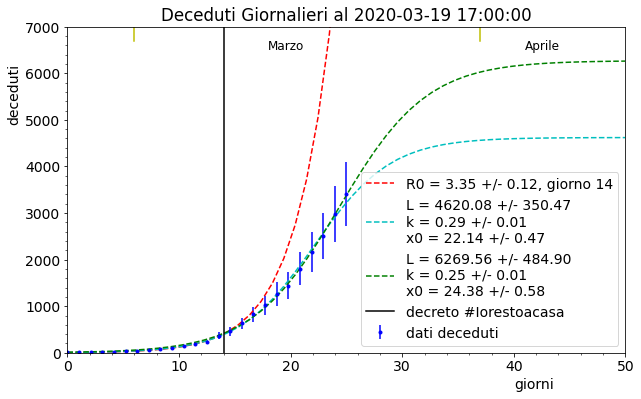

In [6]:
x = np.linspace(0, len(df['data']), len(df['data']))
# confronto con la Gompertz
max_exp_fit = 14
popt_e,pcov_e = curve_fit(Exp,x[x<max_exp_fit], df['deceduti'][x<max_exp_fit], p0=[1,2])
perr_e = np.sqrt(np.diag(pcov_e))
fig, ax = plt.subplots(figsize=(10,6))
err = df['deceduti']/np.sqrt(len(df['deceduti']))
ax.errorbar(x, df['deceduti'], yerr=err, fmt='b.', label='dati deceduti')
min_log_fit = 8
popt_l,pcov_l = curve_fit(Logistic,x[x>min_log_fit], df['deceduti'][x>min_log_fit], 
                          p0=[4000.,4., 10.], sigma=err[x>min_log_fit])
perr_l = np.sqrt(np.diag(pcov_l))
popt_l_0,pcov_l_0 = curve_fit(Logistic,x[x>min_log_fit], df['deceduti'][x>min_log_fit], 
                          p0=[4000.,4., 10.])
perr_l_0 = np.sqrt(np.diag(pcov_l_0))
x=np.linspace(0,50,50)
ax.plot(x, Exp(x, *popt_e), 'r--', label='R0 = {0:.2f} +/- {1:.2f}, giorno {2:d}'.format(popt_e[1], perr_e[1], max_exp_fit))
ax.plot(x, Logistic(x, *popt_l), 'c--', label='L = {0:.2f} +/- {1:.2f}\nk = {2:.2f} +/- {3:.2f} \
\nx0 = {4:.2f} +/- {5:.2f}'.format(popt_l[0], perr_l[0], popt_l[1], perr_l[1], popt_l[2], perr_l[2]))

ax.plot(x, Logistic(x, *popt_l_0), 'g--', label='L = {0:.2f} +/- {1:.2f}\nk = {2:.2f} +/- {3:.2f} \
\nx0 = {4:.2f} +/- {5:.2f}'.format(popt_l_0[0], perr_l_0[0], popt_l_0[1], perr_l_0[1], popt_l_0[2], perr_l_0[2]))
#ax.set_yscale('log')
ax.set_xlim(0,50)
ax.set_ylim(0,7000)
ax.plot([14,14], [0,7000], 'k-', label='decreto #Iorestoacasa')
ax.plot([6,6], [6700,7000], 'y-')
ax.plot([6+31,6+31], [6700,7000], 'y-')
ax.text(6+35, 6500, 'Aprile', fontsize=12)
ax.text(6+12, 6500, 'Marzo', fontsize=12)
ax.legend(loc=4)
ax.set_title('Deceduti Giornalieri al '+str(np.array(df['data'])[-1]))
ax.set_xlabel('giorni', horizontalalignment = 'left', x=0.8)
ax.set_ylabel('deceduti', horizontalalignment = 'left', y=0.7)
plt.minorticks_on()
plt.show()

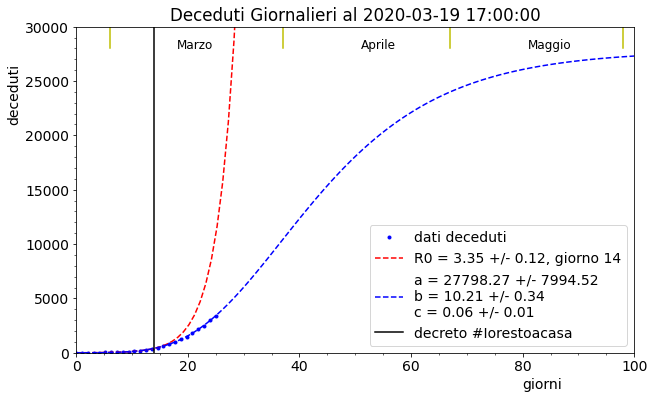

In [7]:
x = np.linspace(0, len(df['data']), len(df['data']))
# confronto con la Gompertz
max_exp_fit = 14
popt_e,pcov_e = curve_fit(Exp,x[x<max_exp_fit], df['deceduti'][x<max_exp_fit], p0=[1,2])
perr_e = np.sqrt(np.diag(pcov_e))
max_gom_fit = 12
popt_g,pcov_g = curve_fit(Gompertz,x[x>max_gom_fit], df['deceduti'][x>max_gom_fit], p0=[4500.,20., 0.01])
perr_g = np.sqrt(np.diag(pcov_g))

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(x, df['deceduti'], 'b.', label='dati deceduti')
x=np.linspace(0,100,100)
ax.plot(x, Exp(x, *popt_e), 'r--', label='R0 = {0:.2f} +/- {1:.2f}, giorno {2:d}'.format(popt_e[1], perr_e[1], max_exp_fit))
ax.plot(x, Gompertz(x, *popt_g), 'b--', label='a = {0:.2f} +/- {1:.2f}\nb = {2:.2f} +/- {3:.2f} \
\nc = {4:.2f} +/- {5:.2f}'.format(popt_g[0], perr_g[0], popt_g[1], perr_g[1], popt_g[2], perr_g[2]))


#ax.set_yscale('log')
ax.set_xlim(0,100)
ax.set_ylim(0,30000)
ax.plot([14,14], [0,30000], 'k-', label='decreto #Iorestoacasa')
ax.plot([6,6], [28000,30000], 'y-')
ax.plot([6+31,6+31], [28000,30000], 'y-')
ax.plot([6+31+30,6+31+30], [28000,30000], 'y-')
ax.plot([6+31+30+31,6+31+30+31], [28000,30000], 'y-')
ax.text(6+12, 28000, 'Marzo', fontsize=12)
ax.text(6+45, 28000, 'Aprile', fontsize=12)
ax.text(6+75, 28000, 'Maggio', fontsize=12)
ax.legend(loc=4)
ax.set_title('Deceduti Giornalieri al '+str(np.array(df['data'])[-1]))
ax.set_xlabel('giorni', horizontalalignment = 'left', x=0.8)
ax.set_ylabel('deceduti', horizontalalignment = 'left', y=0.7)
plt.minorticks_on()
plt.show()


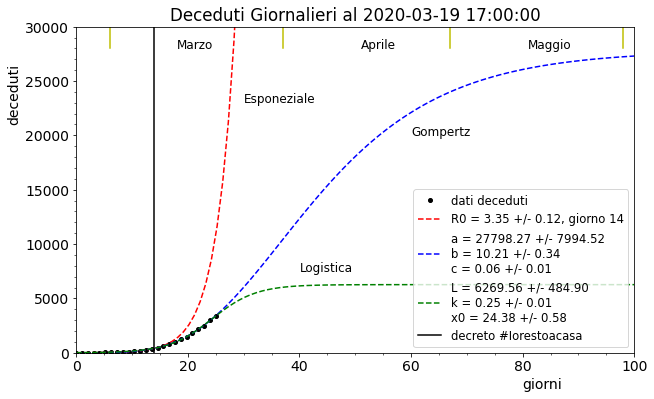

In [8]:
fig, ax = plt.subplots(figsize=(10,6))
x = np.linspace(0, len(df['data']), len(df['data']))
ax.plot(x, df['deceduti'], 'k.', markersize=8, label='dati deceduti')
x=np.linspace(0,100,100)
ax.plot(x, Exp(x, *popt_e), 'r--', label='R0 = {0:.2f} +/- {1:.2f}, giorno {2:d}'.format(popt_e[1], perr_e[1], max_exp_fit))
ax.plot(x, Gompertz(x, *popt_g), 'b--', label='a = {0:.2f} +/- {1:.2f}\nb = {2:.2f} +/- {3:.2f} \
\nc = {4:.2f} +/- {5:.2f}'.format(popt_g[0], perr_g[0], popt_g[1], perr_g[1], popt_g[2], perr_g[2]))
ax.plot(x, Logistic(x, *popt_l_0), 'g--', label='L = {0:.2f} +/- {1:.2f}\nk = {2:.2f} +/- {3:.2f} \
\nx0 = {4:.2f} +/- {5:.2f}'.format(popt_l_0[0], perr_l_0[0], popt_l_0[1], perr_l_0[1], popt_l_0[2], perr_l_0[2]))

#ax.set_yscale('log')
ax.set_xlim(0,100)
ax.set_ylim(0,30000)
ax.plot([14,14], [0,30000], 'k-', label='decreto #Iorestoacasa')
ax.plot([6,6], [28000,30000], 'y-')
ax.plot([6+31,6+31], [28000,30000], 'y-')
ax.plot([6+31+30,6+31+30], [28000,30000], 'y-')
ax.plot([6+31+30+31,6+31+30+31], [28000,30000], 'y-')
ax.text(6+12, 28000, 'Marzo', fontsize=12)
ax.text(6+45, 28000, 'Aprile', fontsize=12)
ax.text(6+75, 28000, 'Maggio', fontsize=12)
ax.text(30, 23000, 'Esponeziale', fontsize=12)
ax.text(60, 20000, 'Gompertz', fontsize=12)
ax.text(40, 7500, 'Logistica', fontsize=12)
ax.legend(loc=4, prop={'size':'small'})
ax.set_title('Deceduti Giornalieri al '+str(np.array(df['data'])[-1]))
ax.set_xlabel('giorni', horizontalalignment = 'left', x=0.8)
ax.set_ylabel('deceduti', horizontalalignment = 'left', y=0.7)
plt.minorticks_on()
plt.show()


In [38]:
# world data
# https://github.com/CSSEGISandData/COVID-19
data_sel = '2020-03-19'
url_csv_file = "https://www.ecdc.europa.eu/sites/default/files/documents/COVID-19-geographic-disbtribution-worldwide-{:s}.xlsx".format(data_sel)
dw = pd.read_excel(url_csv_file)
dw.head()


,DateRep,Day,Month,Year,Cases,Deaths,Countries and territories,GeoId
0,2020-03-19,19,3,2020,0,0,Afghanistan,AF
1,2020-03-18,18,3,2020,1,0,Afghanistan,AF
2,2020-03-17,17,3,2020,5,0,Afghanistan,AF
3,2020-03-16,16,3,2020,6,0,Afghanistan,AF
4,2020-03-15,15,3,2020,3,0,Afghanistan,AF


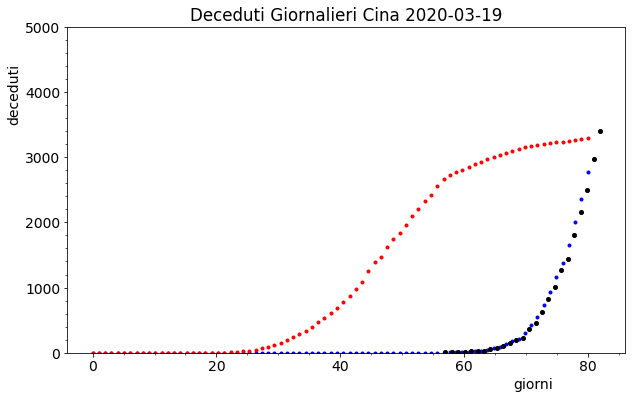

In [39]:
from scipy import integrate
China = dw.loc[(dw['GeoId'] == 'CN')].sort_values(by="DateRep")
Italy = dw.loc[(dw['GeoId'] == 'IT')].sort_values(by="DateRep")
T_days =  len(China)
x = np.linspace(0, T_days, T_days)
fig, ax = plt.subplots(figsize=(10,6))
y_int_IT = integrate.cumtrapz(Italy['Deaths'], x, initial=0)
ax.plot(x, y_int_IT, 'b.', label='dati deceduti')
y_int_CN = integrate.cumtrapz(China['Deaths'], x, initial=0)
ax.plot(x, y_int_CN, 'r.', label='dati deceduti')
x = np.linspace(0+57, len(df['data'])+57, len(df['data']))
ax.plot(x, df['deceduti'], 'k.', markersize=8, label='dati deceduti')
ax.set_ylim(0,5000)
ax.set_title('Deceduti Giornalieri Cina '+data_sel)
ax.set_xlabel('giorni', horizontalalignment = 'left', x=0.8)
ax.set_ylabel('deceduti', horizontalalignment = 'left', y=0.7)
plt.minorticks_on()
plt.show()

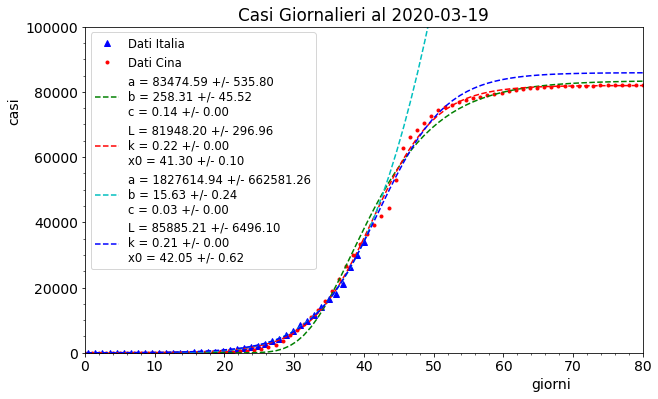

In [101]:
China = dw.loc[(dw['GeoId'] == 'CN')].sort_values(by="DateRep")
Italy = dw.loc[(dw['GeoId'] == 'IT')].sort_values(by="DateRep")
T_days =  len(China)
x = np.linspace(0, T_days, T_days)
ita_offset = 40
fit_cut = 0
fig, ax = plt.subplots(figsize=(10,6))
y_int_IT = integrate.cumtrapz(Italy['Cases'], x, initial=0)
ax.plot(x-ita_offset, y_int_IT, 'b^', label='Dati Italia')
y_int_CN = integrate.cumtrapz(China['Cases'], x, initial=0)
ax.plot(x, y_int_CN, 'r.', label='Dati Cina')
popt_l_c,pcov_l_c = curve_fit(Logistic,x, y_int_CN, p0=[80000.,0.5, 30.])
perr_l_c = np.sqrt(np.diag(pcov_l_c))
popt_g_c,pcov_g_c = curve_fit(Gompertz,x, y_int_CN, p0=[80000.,200., 0.14])
perr_g_c = np.sqrt(np.diag(pcov_g_c))
popt_l_i,pcov_l_i = curve_fit(Logistic,(x-ita_offset)[x>fit_cut], y_int_IT[x>fit_cut], p0=[80000.,0.5, 30.])
perr_l_i = np.sqrt(np.diag(pcov_l_i))
popt_g_i,pcov_g_i = curve_fit(Gompertz,(x-ita_offset)[x>fit_cut], y_int_IT[x>fit_cut], p0=[2000000.,15., 0.03])
perr_g_i = np.sqrt(np.diag(pcov_g_i))
#x = np.linspace(0+57, len(df['data'])+57, len(df['data']))
#ax.plot(x, df['deceduti'], 'k.', markersize=8, label='dati deceduti')
ax.plot(x, Gompertz(x, *popt_g_c), 'g--', label='a = {0:.2f} +/- {1:.2f}\nb = {2:.2f} +/- {3:.2f} \
\nc = {4:.2f} +/- {5:.2f}'.format(popt_g_c[0], perr_g_c[0], popt_g_c[1], perr_g_c[1], popt_g_c[2], perr_g_c[2]))
ax.plot(x, Logistic(x, *popt_l_c), 'r--', label='L = {0:.2f} +/- {1:.2f}\nk = {2:.2f} +/- {3:.2f} \
\nx0 = {4:.2f} +/- {5:.2f}'.format(popt_l_c[0], perr_l_c[0], popt_l_c[1], perr_l_c[1], popt_l_c[2], perr_l_c[2]))
x = np.linspace(-ita_offset, T_days, T_days+ita_offset)
ax.plot(x, Gompertz(x, *popt_g_i), 'c--', label='a = {0:.2f} +/- {1:.2f}\nb = {2:.2f} +/- {3:.2f} \
\nc = {4:.2f} +/- {5:.2f}'.format(popt_g_i[0], perr_g_i[0], popt_g_i[1], perr_g_i[1], popt_g_i[2], perr_g_i[2]))
ax.plot(x, Logistic(x, *popt_l_i), 'b--', label='L = {0:.2f} +/- {1:.2f}\nk = {2:.2f} +/- {3:.2f} \
\nx0 = {4:.2f} +/- {5:.2f}'.format(popt_l_i[0], perr_l_i[0], popt_l_i[1], perr_l_i[1], popt_l_i[2], perr_l_i[2]))
ax.set_ylim(0,100000)
ax.set_xlim(0,80)
ax.set_title('Casi Giornalieri al '+data_sel)
ax.set_xlabel('giorni', horizontalalignment = 'left', x=0.8)
ax.set_ylabel('casi', horizontalalignment = 'left', y=0.7)
plt.minorticks_on()
plt.legend(loc=2, prop={'size':'small'})
plt.show()

In [24]:
China.sort_values(by="DateRep")

,DateRep,Day,Month,Year,Cases,Deaths,Countries and territories,GeoId
1166,2019-12-31,31,12,2019,27,0,China,CN
1165,2020-01-01,1,1,2020,0,0,China,CN
1164,2020-01-02,2,1,2020,0,0,China,CN
1163,2020-01-03,3,1,2020,17,0,China,CN
1162,2020-01-04,4,1,2020,0,0,China,CN
...,...,...,...,...,...,...,...,...
1091,2020-03-15,15,3,2020,22,9,China,CN
1090,2020-03-16,16,3,2020,25,14,China,CN
1089,2020-03-17,17,3,2020,110,9,China,CN
1088,2020-03-18,18,3,2020,33,16,China,CN


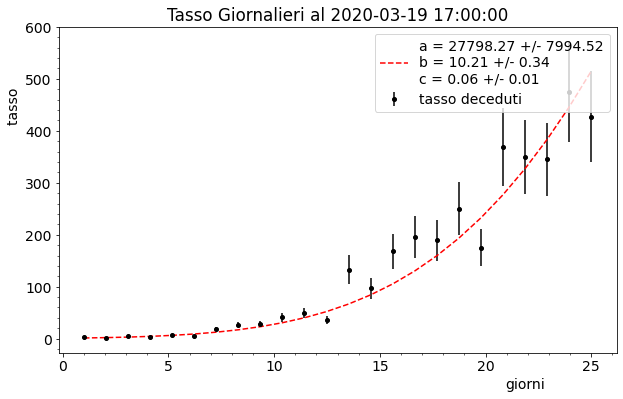

In [11]:
fig, ax = plt.subplots(figsize=(10,6))
x = np.linspace(1, len(df['data']), len(df['data'])-1)
tasso_positivi = []
tasso_deceduti = []
for i in range(1, len(df['data'])):
  tasso_positivi.append(np.array(df['totale_casi'])[i]-np.array(df['totale_casi'])[i-1])
  tasso_deceduti.append(np.array(df['deceduti'])[i]-np.array(df['deceduti'])[i-1])
y = tasso_deceduti
yerr = y/np.sqrt(len(y))
ax.errorbar(x, y, yerr=yerr, fmt='k.', markersize=8, label='tasso deceduti')

popt_gd,pcov_gd = curve_fit(Gompertz,x, y, p0=[4500.,20., 0.01], sigma=yerr)
perr_gd = np.sqrt(np.diag(pcov_gd))

ax.plot(x, Gompertz(x, *popt_gd), 'r--', label='a = {0:.2f} +/- {1:.2f}\nb = {2:.2f} +/- {3:.2f} \
\nc = {4:.2f} +/- {5:.2f}'.format(popt_g[0], perr_g[0], popt_g[1], perr_g[1], popt_g[2], perr_g[2]))

#ax.set_xlim(500,100)
#ax.set_ylim(-500,500)
#ax.plot([14,14], [0,30000], 'k-', label='decreto #Iorestoacasa')
#ax.plot([6,6], [28000,30000], 'y-')
#ax.plot([6+31,6+31], [28000,30000], 'y-')
#ax.plot([6+31+30,6+31+30], [28000,30000], 'y-')
#ax.plot([6+31+30+31,6+31+30+31], [28000,30000], 'y-')
#ax.text(6+12, 28000, 'Marzo', fontsize=12)
#ax.text(6+45, 28000, 'Aprile', fontsize=12)
#ax.text(6+75, 28000, 'Maggio', fontsize=12)
ax.legend(loc=1)
ax.set_title('Tasso Giornalieri al '+str(np.array(df['data'])[-1]))
ax.set_xlabel('giorni', horizontalalignment = 'left', x=0.8)
ax.set_ylabel('tasso ', horizontalalignment = 'left', y=0.7)
plt.minorticks_on()
plt.show()


In [111]:
# DATI COVID REGIONI
url_csv_file = "https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv"
dr = pd.read_csv(url_csv_file)
dr.head()

,data,stato,codice_regione,denominazione_regione,lat,long,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_attualmente_positivi,nuovi_attualmente_positivi,dimessi_guariti,deceduti,totale_casi,tamponi
0,2020-02-24 18:00:00,ITA,13,Abruzzo,42.351222,13.398438,0,0,0,0,0,0,0,0,0,5
1,2020-02-24 18:00:00,ITA,17,Basilicata,40.639471,15.805148,0,0,0,0,0,0,0,0,0,0
2,2020-02-24 18:00:00,ITA,4,P.A. Bolzano,46.499335,11.356624,0,0,0,0,0,0,0,0,0,1
3,2020-02-24 18:00:00,ITA,18,Calabria,38.905976,16.594402,0,0,0,0,0,0,0,0,0,1
4,2020-02-24 18:00:00,ITA,15,Campania,40.839566,14.250850,0,0,0,0,0,0,0,0,0,10


In [112]:
# DATI Popolazione Regioni
url_csv_file = "https://docs.google.com/spreadsheet/ccc?key=1qL5B_J6eV6bD9zicR0YsCIaUMU0BhTdSTrqC1UcDBI8&output=csv"
dpr = pd.read_csv(url_csv_file)
dpr.head()

,Regione,Popolazione,Superficie,Densità,Comuni,Province
0,Lombardia,10060.574,23863.65,422,1506,12
1,Lazio,5879.082,17232.29,341,378,5
2,Campania,5801.692,13670.95,424,550,5
3,Sicilia,4999.891,25832.39,194,390,9
4,Veneto,4905.854,18345.35,267,563,7


In [0]:
data_sel = '2020-03-19 17:00:00'
regioni = np.array(dpr['Regione'])
perc_tamponi = []
perc_positivi = []
perc_deceduti = []
for r in range(0, len(regioni)):
  if regioni[r]=='Trentino Alto Adige':
    popolazione = float(dpr.loc[dpr['Regione']=='Trentino Alto Adige']['Popolazione'].values[0])*1e3
    tamponi = 10000*dr.loc[(dr['denominazione_regione'] == 'P.A. Trento' ) & (dr['data'] == data_sel)]['tamponi'].values[0]
    tamponi = tamponi + 10000*dr.loc[(dr['denominazione_regione'] == 'P.A. Bolzano' ) & (dr['data'] == data_sel)]['tamponi'].values[0]
    perc_tamponi.append(tamponi/popolazione)
    positivi = 10000*dr.loc[(dr['denominazione_regione'] == 'P.A. Trento' ) & (dr['data'] == data_sel)]['totale_casi'].values[0]
    positivi = positivi + 10000*dr.loc[(dr['denominazione_regione'] == 'P.A. Bolzano' ) & (dr['data'] == data_sel)]['totale_casi'].values[0]
    perc_positivi.append(positivi/popolazione)
    deceduti = 10000*dr.loc[(dr['denominazione_regione'] == 'P.A. Trento' ) & (dr['data'] == data_sel)]['deceduti'].values[0]
    deceduti = deceduti + 10000*dr.loc[(dr['denominazione_regione'] == 'P.A. Bolzano' ) & (dr['data'] == data_sel)]['deceduti'].values[0]
    perc_deceduti.append(deceduti/popolazione)

  else:
    popolazione = float(dpr.loc[dpr['Regione']==regioni[r]]['Popolazione'].values[0])*1e3
    tamponi = 10000*dr.loc[(dr['denominazione_regione'] == regioni[r] ) & (dr['data'] == data_sel)]['tamponi'].values[0]
    perc_tamponi.append(tamponi/popolazione)
    positivi = 10000*dr.loc[(dr['denominazione_regione'] == regioni[r] ) & (dr['data'] == data_sel)]['totale_casi'].values[0]
    perc_positivi.append(positivi/popolazione)
    deceduti = 10000*dr.loc[(dr['denominazione_regione'] == regioni[r] ) & (dr['data'] == data_sel)]['deceduti'].values[0]
    perc_deceduti.append(deceduti/popolazione)


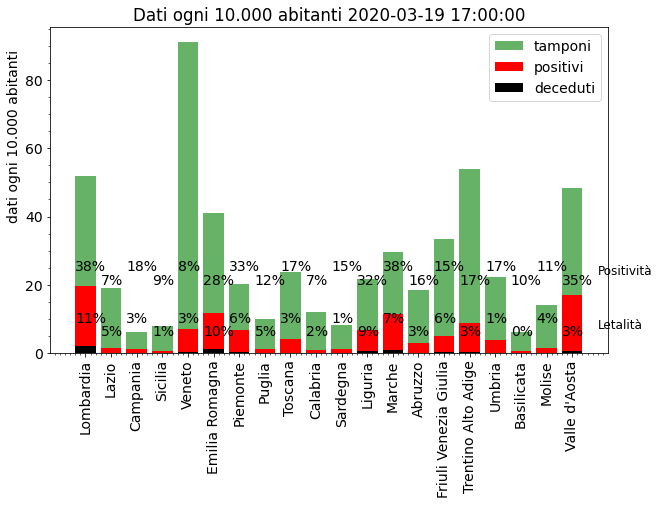

In [121]:
fig, ax = plt.subplots(figsize=(10,6))
ax.bar(regioni, perc_tamponi, label='tamponi', alpha=0.6, color='green')
ax.bar(regioni, perc_positivi, label='positivi', color='red')
ax.bar(regioni, perc_deceduti, label='deceduti', color='black')

for i in range(regioni.size):
  if i % 2 == 0:
    offset = 4
  else:
    offset = 0
  plt.annotate('{:.0f}%'.format(100*perc_positivi[i]/perc_tamponi[i]), (i-0.4,20+offset))
  plt.annotate('{:.0f}%'.format(100*perc_deceduti[i]/perc_positivi[i]), (i-0.4,5+offset))
#ax.set_yscale('log')
ax.text(20, 7, 'Letalità', fontsize=12)
ax.text(20, 23, 'Positività', fontsize=12)
ax.set_title('Dati ogni 10.000 abitanti '+data_sel)
ax.set_ylabel('dati ogni 10.000 abitanti', horizontalalignment = 'left', y=0.4)
plt.xticks(rotation=90)
plt.minorticks_on()
plt.legend()
plt.show()

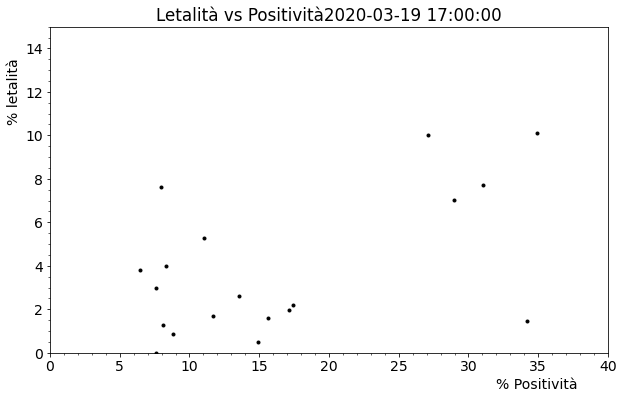

In [115]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(100*np.array(perc_positivi)/np.array(perc_tamponi), 100*np.array(perc_deceduti)/np.array(perc_positivi), 'k.')
plt.minorticks_on()
ax.set_xlim(0,40)
ax.set_ylim(0,15)
ax.set_title('Letalità vs Positività'+str(np.array(df['data'])[-1]))
ax.set_xlabel('% Positività', horizontalalignment = 'left', x=0.8)
ax.set_ylabel('% letalità', horizontalalignment = 'left', y=0.7)
plt.show()

In [235]:
dati_regioni = []
for d in range(1,19):
  data_sel = '2020-03-{:02d} 17:00:00'.format(d)
  print(data_sel)
  try:

    regioni = np.array(dpr['Regione'])
    perc_tamponi = []
    perc_positivi = []
    perc_deceduti = []
    for r in range(0, len(regioni)):
      if regioni[r]=='Trentino Alto Adige':
        popolazione = float(dpr.loc[dpr['Regione']=='Trentino Alto Adige']['Popolazione'].values[0])*1e3
        tamponi = 10000*dr.loc[(dr['denominazione_regione'] == 'P.A. Trento' ) & (dr['data'] == data_sel)]['tamponi'].values[0]
        tamponi = tamponi + 10000*dr.loc[(dr['denominazione_regione'] == 'P.A. Bolzano' ) & (dr['data'] == data_sel)]['tamponi'].values[0]
        perc_tamponi.append(tamponi/popolazione)
        positivi = 10000*dr.loc[(dr['denominazione_regione'] == 'P.A. Trento' ) & (dr['data'] == data_sel)]['totale_casi'].values[0]
        positivi = positivi + 10000*dr.loc[(dr['denominazione_regione'] == 'P.A. Bolzano' ) & (dr['data'] == data_sel)]['totale_casi'].values[0]
        perc_positivi.append(positivi/popolazione)
        deceduti = 10000*dr.loc[(dr['denominazione_regione'] == 'P.A. Trento' ) & (dr['data'] == data_sel)]['deceduti'].values[0]
        deceduti = deceduti + 10000*dr.loc[(dr['denominazione_regione'] == 'P.A. Bolzano' ) & (dr['data'] == data_sel)]['deceduti'].values[0]
        perc_deceduti.append(deceduti/popolazione)

      else:
        popolazione = float(dpr.loc[dpr['Regione']==regioni[r]]['Popolazione'].values[0])*1e3
        tamponi = 10000*dr.loc[(dr['denominazione_regione'] == regioni[r] ) & (dr['data'] == data_sel)]['tamponi'].values[0]
        perc_tamponi.append(tamponi/popolazione)
        positivi = 10000*dr.loc[(dr['denominazione_regione'] == regioni[r] ) & (dr['data'] == data_sel)]['totale_casi'].values[0]
        perc_positivi.append(positivi/popolazione)
        deceduti = 10000*dr.loc[(dr['denominazione_regione'] == regioni[r] ) & (dr['data'] == data_sel)]['deceduti'].values[0]
        perc_deceduti.append(deceduti/popolazione)
    dati_regioni.append([d, data_sel, np.array(perc_tamponi), np.array(perc_positivi), np.array(perc_deceduti)])
  except:
    print ('No Data') 
  

2020-03-01 17:00:00
2020-03-02 17:00:00
No Data
2020-03-03 17:00:00
No Data
2020-03-04 17:00:00
2020-03-05 17:00:00
2020-03-06 17:00:00
2020-03-07 17:00:00
No Data
2020-03-08 17:00:00
No Data
2020-03-09 17:00:00
No Data
2020-03-10 17:00:00
No Data
2020-03-11 17:00:00
2020-03-12 17:00:00
2020-03-13 17:00:00
2020-03-14 17:00:00
2020-03-15 17:00:00
2020-03-16 17:00:00
2020-03-17 17:00:00
2020-03-18 17:00:00


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


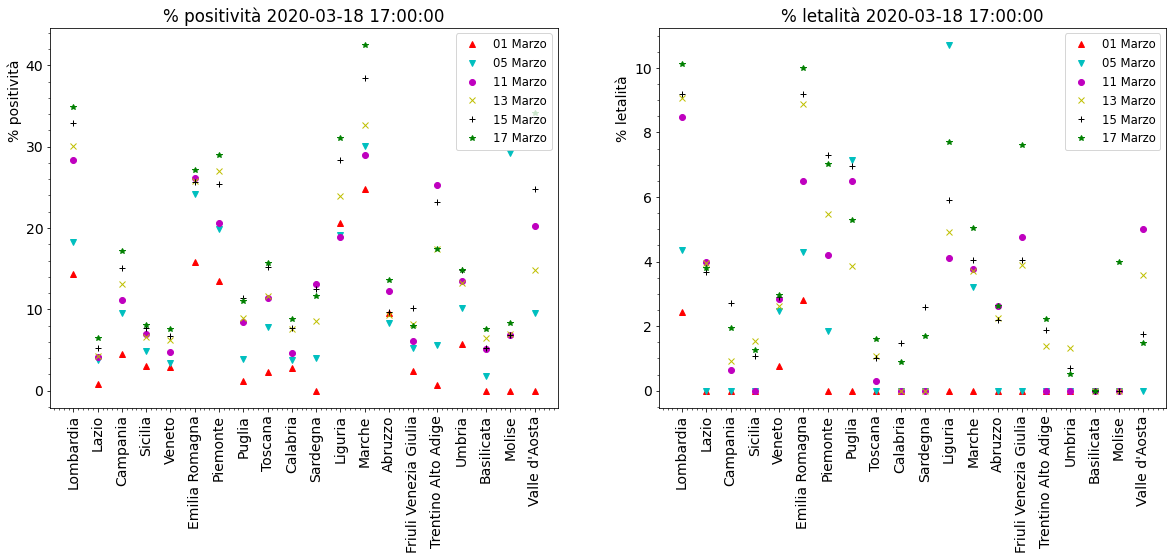

In [350]:
dati_regioni = np.array(dati_regioni)
col    = ('b.', 'r^', 'cv', 'mo', 'yx', 'k+', 'g*')
fig, ax = plt.subplots(1, 2, figsize=(20,7))
coli = 0
for d in range(0, len(dati_regioni), 2 ):
  coli +=1
  ax[0].plot(regioni, 100*dati_regioni[d][3]/dati_regioni[d][2], col[coli], label='{:02d} Marzo'.format(dati_regioni[d][0]))
  ax[1].plot(regioni, 100*dati_regioni[d][4]/dati_regioni[d][3], col[coli], label='{:02d} Marzo'.format(dati_regioni[d][0]))
ax[0].set_title('% positività '+data_sel)
ax[0].set_ylabel('% positività', horizontalalignment = 'left', y=0.7)
ax[1].set_title('% letalità '+data_sel)
ax[1].set_ylabel('% letalità', horizontalalignment = 'left', y=0.7)

ax[0].set_xticklabels(regioni, rotation=90)
ax[0].minorticks_on()
ax[0].legend(loc=1, prop={'size':'small'})
ax[1].set_xticklabels(regioni, rotation=90)
ax[1].minorticks_on()
ax[1].legend(loc=1, prop={'size':'small'})
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  


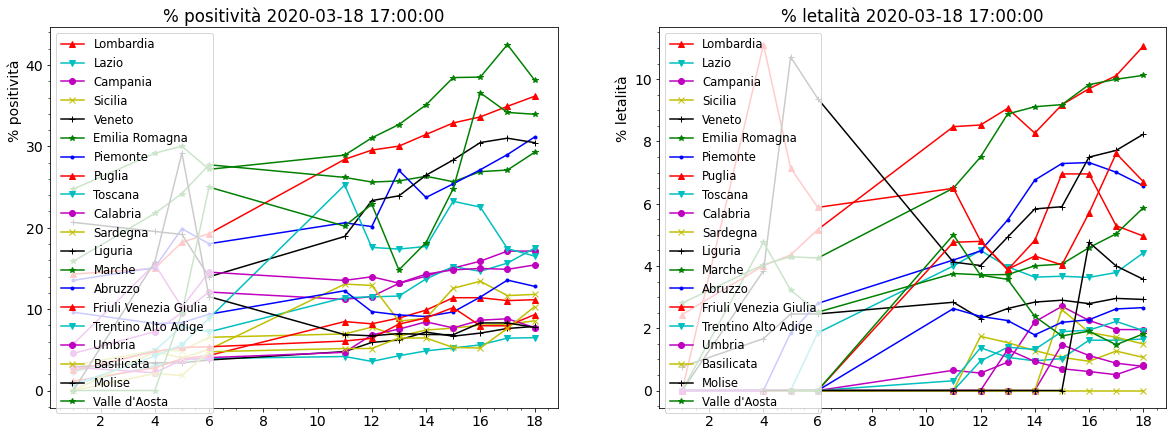

In [384]:
from matplotlib.ticker import MaxNLocator
col    = ('b.-', 'r^-', 'cv-', 'mo-', 'yx-', 'k+-', 'g*-')
fig, ax = plt.subplots(1, 2, figsize=(20,7))

coli = 0
for r in range(0, len(regioni)):
  positivity = []
  letality = []
  coli +=1
  if coli >= len(col):
    coli = 0
  for d in range(0,len(dati_regioni)):
    positivity.append([100*dati_regioni[d][3][r]/dati_regioni[d][2][r]])
    letality.append(  [100*dati_regioni[d][4][r]/dati_regioni[d][3][r]])
    

  ax[0].plot(dati_regioni[:,0], positivity, col[coli], label='{:s}'.format(regioni[r]))
  ax[1].plot(dati_regioni[:,0], letality, col[coli], label='{:s}'.format(regioni[r]))
ax[0].set_title('% positività '+data_sel)
ax[0].set_ylabel('% positività', horizontalalignment = 'left', y=0.7)
ax[1].set_title('% letalità '+data_sel)
ax[1].set_ylabel('% letalità', horizontalalignment = 'left', y=0.7)

ax[0].xaxis.set_major_locator(MaxNLocator(integer=True))
ax[0].minorticks_on()
ax[0].legend(loc=2, prop={'size':'small'})
ax[1].xaxis.set_major_locator(MaxNLocator(integer=True))
ax[1].minorticks_on()
ax[1].legend(loc=2, prop={'size':'small'})
plt.show()

In [352]:
positivity = []
letality = []
d = 0
for r in range(len(dati_regioni)):
  positivity.append([100*dati_regioni[:,3][r][d]/dati_regioni[:,2][r][d]])
  letality.append(  [100*dati_regioni[:,4][r][d]/dati_regioni[:,3][r][d]])
  y.append([dati_regioni[:,2][r][d]])


12


In [360]:
dati_regioni[d][2][r]

array([ 6.83758203,  1.23148478,  0.64291589,  0.58201269, 18.45957911,
        4.02513568,  0.8309602 ,  0.65027688,  1.53365967,  0.17975164,
        0.17687338,  0.78032296,  0.66217741,  0.39646838,  1.99963793,
        1.32428591,  0.39681865,  0.6928788 ,  0.19632416,  0.79576019])

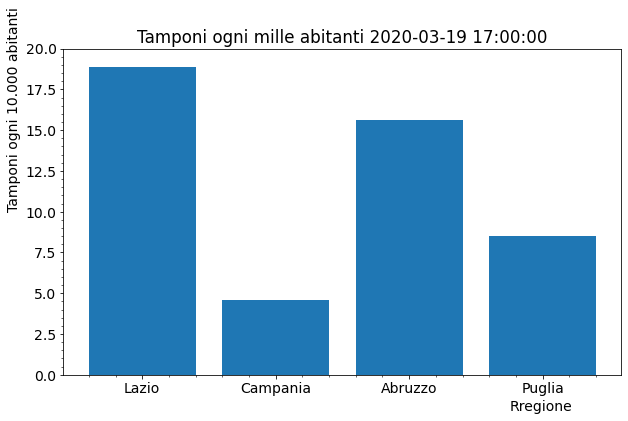

In [350]:
P_Lazio = 5.897e6
P_Campania = 5.827e6
P_Abruzzo = 1.315e6
P_Puglia = 4.048e6
y = [(10000*dr.loc[(dr['denominazione_regione'] == 'Lazio') & (dr['data'] == '2020-03-18 17:00:00')]['tamponi'].values/P_Lazio)[0],
     (10000*dr.loc[(dr['denominazione_regione'] == 'Campania') & (dr['data'] == '2020-03-18 17:00:00')]['tamponi'].values/P_Campania)[0],
     (10000*dr.loc[(dr['denominazione_regione'] == 'Abruzzo') & (dr['data'] == '2020-03-18 17:00:00')]['tamponi'].values/P_Abruzzo)[0],
     (10000*dr.loc[(dr['denominazione_regione'] == 'Puglia') & (dr['data'] == '2020-03-18 17:00:00')]['tamponi'].values/P_Puglia)[0]
     ]
fig, ax = plt.subplots(figsize=(10,6))
xl = ['Lazio', 'Campania', 'Abruzzo', 'Puglia']
x = [0,1,2,3]
#ax.plot(xl, y, linestyle='dashed')
ax.bar(xl, y)
#ax.set_xticks(x, xl)
ax.set_ylim(0, 20)
ax.set_title('Tamponi ogni mille abitanti '+str(np.array(df['data'])[-1]))
ax.set_xlabel('Rregione', horizontalalignment = 'left', x=0.8)
ax.set_ylabel('Tamponi ogni 10.000 abitanti', horizontalalignment = 'left', y=0.5)
plt.minorticks_on()
plt.show()

In [354]:
len(df)

25